# 2018 Yellow Taxi Trip Data

In [2]:
# %matplotlib
import pandas as pd
import numpy as np
import random as rd
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Ruta de datos

In [3]:
ruta = "/home/christo/Downloads/Compressed"
archivo = "2018_Yellow_Taxi_Trip_Data.csv"

### Matriz predictiva

En principio solo es necesario conocer la cantidad de viajes por hora durante el 2018, y construiremos la matriz predictiva a partir de esos datos.
Creamos una función que nos de la hora en formato 24 horas, esto para que sea más rápido el código.

In [3]:
def hora(hora, meridiano):
    if meridiano == "AM":
        return hora % 12
    elif meridiano == "PM":
        return 12 + (hora % 12)

In [4]:
# Manipulación de datos por chunks
chunk_list = []
contador = 0
for chunk in pd.read_csv(os.path.join(ruta,archivo), usecols = ["tpep_pickup_datetime"] ,chunksize = 500000, iterator = True):
    tiempo = pd.DataFrame()
    tiempo["fecha"] = chunk["tpep_pickup_datetime"].map(lambda x: x[:5]) # solo le falta el año
    tiempo["hora"] = chunk["tpep_pickup_datetime"].map(lambda x: hora(int(x[11:13]), x[-2:]))
    tiempo["viajes"] = 1 # Creamos contador de filas(viajes)
    tiempo = tiempo.groupby(["fecha", "hora"], as_index = False,sort = False).aggregate("count")
    contador += 1
    print(contador)
    chunk_list.append(tiempo)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225


In [21]:
prueba = pd.concat(chunk_list, axis = 0).groupby(["fecha", "hora"], as_index = False,sort = False).aggregate("sum")

In [22]:
prueba.to_pickle("./prueba.pkl")

In [23]:
?pd.to_pickle

In [4]:
prueba = pd.read_pickle("./prueba.pkl")

In [5]:
prueba["fecha"] = pd.to_datetime(prueba["fecha"].map(lambda x: x +"/2018"), format = "%m/%d/%Y")

In [6]:
prueba = prueba.sort_values(["fecha", "hora"]).reset_index(drop = True)

In [7]:
prueba

,fecha,hora,viajes
0,2018-01-01,0,16783
1,2018-01-01,1,19061
2,2018-01-01,2,16601
3,2018-01-01,3,12631
4,2018-01-01,4,8740
...,...,...,...
8755,2018-12-31,19,14876
8756,2018-12-31,20,14435
8757,2018-12-31,21,14117
8758,2018-12-31,22,10741


In [8]:
# Matriz predictiva usando los viajes de horas anteriores

n = 24 # NÚMERO DE HORAS ANTERIORES
matriz_pred = pd.DataFrame([list(prueba["viajes"][(0 + i):(n + 1 + i)])  for i in range(len(prueba) - n)])

# Renombrando columnas
new_columns = ["Ant_" + str(n-int(v)) for v in matriz_pred.columns[0:-1]] + ["Y"]
matriz_pred.columns = new_columns

# Matriz X,y
X = matriz_pred.iloc[:,0:-1].copy()
y = matriz_pred.iloc[:,-1].copy()

matriz_pred.head()

,Ant_24,Ant_23,Ant_22,Ant_21,Ant_20,Ant_19,Ant_18,Ant_17,Ant_16,Ant_15,...,Ant_9,Ant_8,Ant_7,Ant_6,Ant_5,Ant_4,Ant_3,Ant_2,Ant_1,Y
0,16783,19061,16601,12631,8740,4229,3414,3433,3643,4940,...,13277,12552,12759,11821,10458,8357,8852,7906,5411,3584
1,19061,16601,12631,8740,4229,3414,3433,3643,4940,6974,...,12552,12759,11821,10458,8357,8852,7906,5411,3584,1724
2,16601,12631,8740,4229,3414,3433,3643,4940,6974,9984,...,12759,11821,10458,8357,8852,7906,5411,3584,1724,1205
3,12631,8740,4229,3414,3433,3643,4940,6974,9984,11627,...,11821,10458,8357,8852,7906,5411,3584,1724,1205,918
4,8740,4229,3414,3433,3643,4940,6974,9984,11627,11897,...,10458,8357,8852,7906,5411,3584,1724,1205,918,1214


### Modelos

#### Árbol de Regresión

Un árbol de regresión consiste en hacer preguntas de tipo ¿$x_k \leq c$? para cada una de las covariables, de esta forma el espacio de las covariables es divido en hiper-rectángulos y todas las observaciones que queden dentro de un hiper-rectángulo tendrán el mismo valor estimado $\hat{y}$.

En la siguiente figura se ilustra el árbol en el lado izquierdo y la partición del espacio en el lado derecho. La partición del espacio se hace de manera repetitiva para encontrar las variables y los valores de corte $c$ de tal manera que se minimice la función de costos $\sum_{i = 1}^n (y_i - \hat{y_i})^2$ (Puede ser una métrica distinta a $L_2$). 

<img src="arbol_regre.png">

Los pasos para realizar la partición del espacio son:

* Dado un conjunto de covariables (características), encontrar la covariable que permita predecir mejor la variable respuesta.
* Encontrar el punto de corte  $c$ sobre esa covariable que permita predecir mejor la variable respuesta.
* Repetir los pasos anteriores hasta que se alcance el criterio de parada.

https://fhernanb.github.io/libro_mod_pred/arb-de-regre.html#ref-Breiman1984

In [66]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, SCORERS, r2_score

# Setting parameters
hyper_param = dict(criterion = ["mse", "friedman_mse", "mae", "poisson"], # Puede agregarse friedman_mse, son metricas.
                    splitter = ["best", "random"],
                    max_depth = range(2,20),
                    min_samples_leaf = [50,100,150]) # Si de las carac. mira a todos o toma una aleatorio

# Splitting data
Xt, Xv, yt, yv = train_test_split(X,y,train_size = 0.7)

# Shape
print(Xt.shape, Xv.shape, yt.shape, yv.shape)

# Creating model
modelo = DecisionTreeRegressor()

# Creating grid
# https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
grid = GridSearchCV(estimator = modelo,  #Modelo sujeto de la hiperparametrización
                    param_grid = hyper_param, #Espacio paramétrico
                    cv = 5, #Número de dobleces (Folds)
                    n_jobs = -1, #Procesadores a usar (-1 == todos)
                    scoring = 'neg_mean_absolute_error', #Métrica para seleccionar el mejor modelo
                    verbose = True) #Nos informa del estado del entrenamiento

(6114, 25) (2621, 25) (6114,) (2621,)


In [67]:
grid.fit(Xt,yt)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1616 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  4.6min finished


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
                         'max_depth': range(2, 20),
                         'min_samples_leaf': [50, 100, 150],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error', verbose=True)

In [84]:
print("Mejores parametros: ", grid.best_params_)
print("Mejor std: ", pd.DataFrame(grid.cv_results_).sort_values("rank_test_score")["std_test_score"][0])
print("Mejor score: ", np.abs(grid.best_score_))

Mejores parametros:  {'learning_rate': 'constant', 'hidden_layer_sizes': (25, 36, 27), 'alpha': 0.4677000000000114, 'activation': 'relu'}
Mejor std:  15.32078342506608
Mejor score:  647.4804541760373


In [69]:
modelo = grid.best_estimator_ # Elegimos el mejor modelo
modelo.fit(Xt,yt) # Entrenamos el modelo
yt_predict = np.round(modelo.predict(Xt)) # Nos interesan enteros por eso redondeamos 
yv_predict = np.round(modelo.predict(Xv)) 

In [70]:
print("MAE para entrenamiento: ", mean_absolute_error(y_true = yt, y_pred = yt_predict))
print("MAE para validación: ", mean_absolute_error(y_true = yv, y_pred = yv_predict))

MAE para entrenamiento:  884.9587831207066
MAE para validación:  943.7283479587943


In [71]:
print("MSE para entrenamiento: ", mean_squared_error(y_true = yt, y_pred = yt_predict))
print("MSE para validación: ", mean_squared_error(y_true = yv, y_pred = yv_predict))

MSE para entrenamiento:  2647119.110238796
MSE para validación:  2510179.0385349104


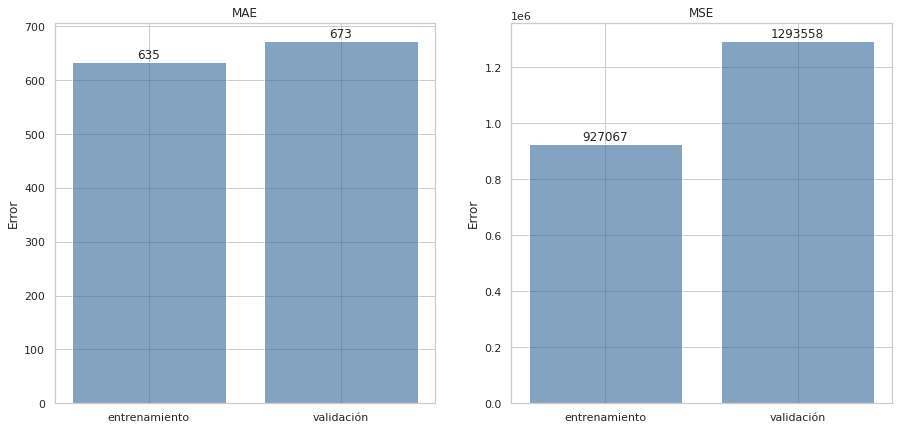

In [130]:
mae = [mean_absolute_error(y_true = yt, y_pred = yt_predict),
       mean_absolute_error(y_true = yv, y_pred = yv_predict)]

mse = [mean_squared_error(y_true = yt, y_pred = yt_predict),
       mean_squared_error(y_true = yv, y_pred = yv_predict)]

nombres = ["entrenamiento", "validación"]

# Gráficas MAE y MSE
plt.get_cmap("cool")
plt.figure(figsize=(15,7))

plt.subplot(1, 2, 1)
plt.bar(nombres, mae, color = (0.2, 0.4, 0.6, 0.6))
for i in range(len(mae)):
    plt.annotate(str(round(mae[i])), xy = (nombres[i], mae[i]), ha='center', va='bottom')
plt.ylabel("Error")
plt.title("MAE")

plt.subplot(1, 2, 2)
plt.bar(nombres, mse, color = (0.2, 0.4, 0.6, 0.6))
for i in range(len(mse)):
    plt.annotate(str(round(mse[i])), xy = (nombres[i], mse[i]), ha='center', va='bottom')
plt.ylabel("Error")
plt.title("MSE")

plt.show()


Text(0.5, 1.0, 'Volumen real vs predicción(Entrenamiento)')

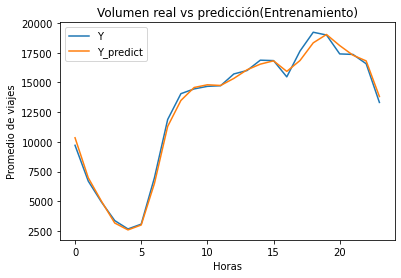

In [72]:
tabla_vs = pd.concat([Xt.reset_index(drop=1), yt.reset_index(drop=1), pd.Series(yt_predict, name = "Y_predict")], axis = 1)[["X_0","Y","Y_predict"]]
tabla_vs.groupby("X_0").agg("mean").plot()
plt.xlabel("Horas")
plt.ylabel("Promedio de viajes")
plt.title("Volumen real vs predicción(Entrenamiento)")

Text(0.5, 1.0, 'Volumen real vs predicción(Validación)')

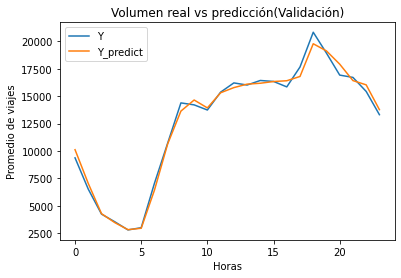

In [73]:
tabla_vs = pd.concat([Xv.reset_index(drop=1), yv.reset_index(drop=1), pd.Series(yv_predict, name = "Y_predict")], axis = 1)[["X_0","Y","Y_predict"]]
tabla_vs.groupby("X_0").agg("mean").plot()
plt.xlabel("Horas")
plt.ylabel("Promedio de viajes")
plt.title("Volumen real vs predicción(Validación)")

#### Red Neuronal

In [16]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import  mean_squared_error, mean_absolute_error, SCORERS, r2_score


# Setting parameters
hyper_param = dict(hidden_layer_sizes=[(a,b,c,) for a in range(20,30,1) for b in range(30,40,1) for c in range(20,30,1)],
                   activation = ['identity', 'logistic', 'tanh', 'relu'],
                   alpha = np.arange(0.01,0.9,0.0001),
                   learning_rate = ['constant', 'invscaling', 'adaptive'],
                  )
# Splitting data
Xt, Xv, yt, yv = train_test_split(X,y,train_size = 0.7)

# Shape
print(Xt.shape, Xv.shape, yt.shape, yv.shape)

# Creating model
modelo = MLPRegressor()

# Creating grid
# https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
grid = RandomizedSearchCV(estimator = modelo,#Modelo sujeto de la hiperparametrización
                    n_iter = 500,
                    param_distributions = hyper_param, #Espacio paramétrico
                    cv = 3, #Número de dobleces (Folds)
                    n_jobs = 4, #Procesadores a usar (-1 == todos)
                    scoring = 'neg_mean_absolute_error', #Métrica para seleccionar el mejor modelo
                    verbose = True) #Nos informa del estado del entrenamiento

(6098, 48) (2614, 48) (6098,) (2614,)


In [17]:
grid.fit(Xt,yt)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 10.7min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 20.9min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 33.1min
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed: 40.8min finished
/home/christo/entornos/tsc/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=MLPRegressor(), n_iter=500, n_jobs=4,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': array([0.01  , 0.0101, 0.0102, ..., 0.8997, 0.8998, 0.8999]),
                                        'hidden_layer_sizes': [(20, 30, 20),
                                                               (20, 30, 21),
                                                               (20, 30, 22),
                                                               (20, 30, 23),
                                                               (20, 30, 24),
                                                               (20, 30, 25),
                                                               (20, 30, 26),
                                                               (20, 30, 27),
                                                 

In [18]:
print("Mejores parametros: ", grid.best_params_)
print("Desviación estándar: ", pd.DataFrame(grid.cv_results_).sort_values(by = "rank_test_score").reset_index()["std_test_score"][0])
print("Mejor score: ", np.abs(grid.best_score_))

Mejores parametros:  {'learning_rate': 'invscaling', 'hidden_layer_sizes': (29, 35, 27), 'alpha': 0.7092999999999958, 'activation': 'relu'}
Desviación estándar:  9.807114476105914
Mejor score:  633.0252488699439


In [ ]:
modelo = grid.best_estimator_ # Elegi  mos el mejor modelo
modelo.max_iter = len(matriz_pred)*2 # Max iteraciones
modelo.fit(Xt,yt) # Entrenamos el modelo
yt_predict = np.round(modelo.predict(Xt)) # Nos interesan enteros por eso redondeamos 
yv_predict = np.round(modelo.predict(Xv)) 

In [79]:
print("MAE para entrenamiento: ", mean_absolute_error(y_true = yt, y_pred = yt_predict))
print("MAE para validación: ", mean_absolute_error(y_true = yv, y_pred = yv_predict))

MAE para entrenamiento:  634.7054301602878
MAE para validación:  673.1816100724914


In [80]:
print("MSE para entrenamiento: ", mean_squared_error(y_true = yt, y_pred = yt_predict))
print("MSE para validación: ", mean_squared_error(y_true = yv, y_pred = yv_predict))

MSE para entrenamiento:  927067.1437684004
MSE para validación:  1293558.3864937047


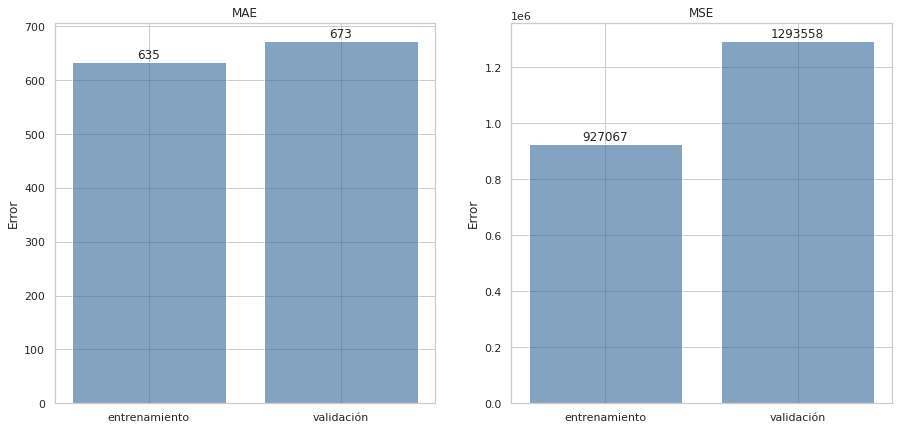

In [131]:
mae = [mean_absolute_error(y_true = yt, y_pred = yt_predict),
       mean_absolute_error(y_true = yv, y_pred = yv_predict)]

mse = [mean_squared_error(y_true = yt, y_pred = yt_predict),
       mean_squared_error(y_true = yv, y_pred = yv_predict)]

nombres = ["entrenamiento", "validación"]

# Gráficas MAE y MSE
plt.get_cmap("cool")
plt.figure(figsize=(15,7))

plt.subplot(1, 2, 1)
plt.bar(nombres, mae, color = (0.2, 0.4, 0.6, 0.6))
for i in range(len(mae)):
    plt.annotate(str(round(mae[i])), xy = (nombres[i], mae[i]), ha='center', va='bottom')
plt.ylabel("Error")
plt.title("MAE")

plt.subplot(1, 2, 2)
plt.bar(nombres, mse, color = (0.2, 0.4, 0.6, 0.6))
for i in range(len(mse)):
    plt.annotate(str(round(mse[i])), xy = (nombres[i], mse[i]), ha='center', va='bottom')
plt.ylabel("Error")
plt.title("MSE")

plt.show()

Text(0.5, 1.0, 'Volumen real vs predicción(Entrenamiento)')

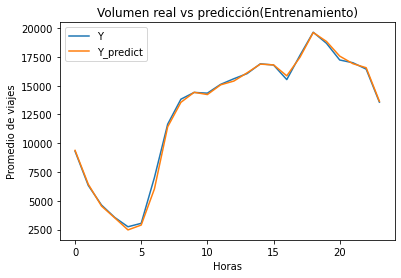

In [81]:
tabla_vs = pd.concat([Xt.reset_index(drop=1), yt.reset_index(drop=1), pd.Series(yt_predict, name = "Y_predict")], axis = 1)[["X_0","Y","Y_predict"]]
tabla_vs.groupby("X_0").agg("mean").plot()
plt.xlabel("Horas")
plt.ylabel("Promedio de viajes")
plt.title("Volumen real vs predicción(Entrenamiento)")

Text(0.5, 1.0, 'Volumen real vs predicción(Validación)')

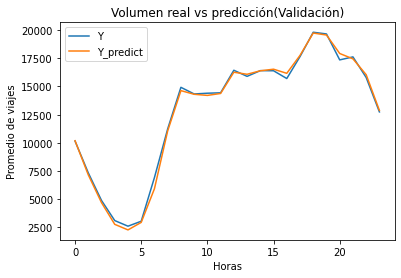

In [82]:
tabla_vs = pd.concat([Xv.reset_index(drop=1), yv.reset_index(drop=1), pd.Series(yv_predict, name = "Y_predict")], axis = 1)[["X_0","Y","Y_predict"]]
tabla_vs.groupby("X_0").agg("mean").plot()
plt.xlabel("Horas")
plt.ylabel("Promedio de viajes")
plt.title("Volumen real vs predicción(Validación)")